# Ανάλυση SARS-nCoV-2 στην Ελλάδα και σύγκριση με άλλες ευρωπαϊκές χώρες
# Εισαγωγή
---

ΤODO

## Install the dependencies

In [903]:
!pip install pandas bokeh numpy scipy folium ipywidgets_bokeh countryinfo

# Σύγκριση Μολύνσεων ανά Πόλη
---

Βλέπουμε χάρτη και διάγραμμα για τη κατανομή των μολύνσεων ανά πόλη. 
H Αθήνα έχει τα περισσότερα κρούσματα. Ακολουθούν η Καστοριά (ταξίδι στην Ιταλία για έκθεση μόδας) και η Ηλεία (εκδρομή στους άγιους τόπους)

Το Υπουργείο Υγείας πρόσφατα ανακοίνωσε [επίσημα στατιστικά πάνω στο θέμα](https://eody.gov.gr/wp-content/uploads/2020/03/covid-gr-daily-report-20200320.pdf).

In [904]:
import pandas as pd
from bokeh.plotting import figure
from bokeh.models import HoverTool
from bokeh.io import show, output_notebook
from bokeh.layouts import row
import math

output_notebook()

names = ["city", "latitude", "longitude", "infections"]
df = pd.read_csv(
    'cities.csv',
    names=names,
)

data = df.loc[:, ['city', 'infections']]
data = data.sort_values(ascending=True, by=['infections'])

p = figure(x_range=data['city'], title="Μολύνσεις ανά πόλη",
           x_axis_label="Πόλη", y_axis_label="Αριθμός Ανθρώπων", width = 750)
p.xaxis.major_label_orientation = math.pi/2
p.vbar(x=data['city'], top=data['infections'], width=0.9)
p.tools = [] # disable zoom / pan
p.add_tools(HoverTool(tooltips=[("City", "@x"), ("Infected", "@top")]))
p.xgrid.grid_line_color = None
p.y_range.start = 0
p.toolbar.logo = None
p.toolbar_location = None


show(p)

Loading BokehJS ...

In [905]:
import folium

MAGNIFICATION = 100

# map centered at Athens
map = folium.Map(
    location=[37.9838, 23.7275],
    width=750, height=750,
    max_bounds=True,
    max_zoom=12, min_zoom=6,
)

for i, city in df.dropna().iterrows():
    # add a tooltip showing the number of infections on top
    popup = folium.Popup(str(city["infections"]), sticky=True, show=True)
    folium.Circle(
        location=[
            city["latitude"],
            city["longitude"]
        ],
        radius=city["infections"] * MAGNIFICATION,
        color="red",
        sticky=True,
        show=True,
        fill=True,  # Set fill to True
        fill_opacity=0.7
    ).add_child(popup).add_to(map)

sw = df[['latitude', 'longitude']].min().values.tolist()
ne = df[['latitude', 'longitude']].max().values.tolist()
map.fit_bounds([sw, ne])

map

## Κρούσματα (ανά ημέρα / συνολικά)
---

Το παρακάτω διάγραμμα είναι βασισμένο στα επίσημα δεδομένα που ανακοινώνονται καθημερινά απο το Υπουργείο Υγείας.

In [906]:
from bokeh.models import ColumnDataSource

# load the data
names = ["date", "infections", "incident"]
ts = pd.read_csv(
    'greece.csv',
    names=names,
    header=0,
)

ts['date'] = pd.to_datetime(ts['date'], dayfirst=True)
ts['total'] = ts['infections'].cumsum()

# infections graph
p = figure(
    title = "Κρούσματα", 
    x_axis_label = "Date", 
    y_axis_label = "Αριθμός Ανθρώπων", 
    x_axis_type = "datetime",
    height = 500, 
)
p.tools = []

def hover(renderer, tooltips):
    hover = HoverTool(
        renderers = [renderer],
        mode = "vline",
        tooltips = tooltips,
        formatters={"@date": "datetime"}
    )
    return hover

source = ColumnDataSource(data = ts)
per_day = p.line(x="date", y="infections", source=source, legend_label = 'Κρούσματα ανά ημέρα')
total = p.line(x="date", y="total", source=source, color = 'green', legend_label = 'Συνολικά Κρούσματα')

p.add_tools(hover(per_day, [("date", "@date{%F}"), ("New infections", "@infections")]))
p.add_tools(hover(total, [("Total Infections", "@total")]))

# show the legend in a nice place
p.legend.location = "top_left"
p.legend.click_policy="hide"

show(p)

## Σύγκριση με άλλες χώρες
---

Για να συγκρίνουμε την ελληνική κατάσταση με άλλες Ευρωπαϊκές χώρες, θα χρησιμοποιήσουμε το [dataset απο το John Hopkins University](https://github.com/CSSEGISandData/COVID-19)

## Ας συγκρίνουμε τις μολύνσεις / θανάτους σε ήμερες από τα πρώτα 100 κρούσματα / 10 θανάτους

Στο παρακάτω διάγραμμα βλέπουμε πως έχουν εξελιχτεί τα κρούσματα και οι θάνατοι ανά χώρα. Χρησιμοποιύμε τα πρώτα 100 κρούσματα και τους πρώτους 10 θανάτους σαν αρχική χρονική στιγμή, για να υπολογίσουμε πόσο "πίσω" είναι η κάθε χώρα, σε σχέση με την Ιταλία (η οποία θεωρείται η πιο σοβαρή περίπτωση αυτή τη στιγμή).

### Κρούσματα:
- Ελλάδα: -19 ημέρες
- Ηνωμένο Βασίλειο: -11 ημέρες
- Ισπανία: -8 ημέρες
- Γερμανία: -7 ημέρες

### Θάνατοι:
- Ελλάδα: ? (δεν έχει φτάσει ακόμα 10 θανάτους)
- Ηνωμένο Βασίλειο: -17 ημέρες
- Ισπανία: -11 ημέρες
- Γερμανία: -18 ημέρες

**Σημαντική παρατήρηση**: Ενώ η Ισπανία και η Γερμανία έχουν αντίστοιχους αριθμούς κρουσμάτων, οι θάνατοι που έχουν σημειωθεί στην Ισπανία είναι πολλαπλάσιοι.

> Μπορείς να κλικάρεις στο όνομα της κάθε χώρας για να κρύψεις το διάγραμμά της. 


### Ελλάδα και Ηνωμένο Βασίλειο

Φαίνεται ότι η Ελλάδα και το Ηνωμένο Βασίλειο ακολουθούν παρόμοια πορεία (τα δύο διαγράμματα είναι ακριβώς το ένα πάνω στο άλλο στις πρώτες 8 ημέρες). Και οι δύο φαίνονται συγκριτικά καλύτερα από την Ισπανία και τη Γερμανία. Αυτό όμως μπορεί να συμβαίνει διότι και η Ισπανία και η Γερμανία κάνουν πιο εκτεταμένα τέστ, σε σχέση με την Ελλάδα και το Ηνωμένο Βασίλειο.

_Αυτό που με ανησυχεί περισσότερο είναι το εξής:_

Η κοινωνική απομάκρυνση (και όχι καραντίνα) ξεκίνησε πριν 7 ημέρες. Πιστεύω ότι όσο ανακοινώνονται "μικρά" νούμερα (<50) κάθε μέρα, ο κόσμος θα νομίζει ότι ο κίνδυνος έχει περάσει, και θα σταματήσει να βλέπει την κατάσταση σοβαρά, με αποτέλεσμα να αρχίσει να ξανακυκλοφορεί στους δρόμους.

Φυσικά, δεν θα έχει γίνει αντιληπτό ότι λόγω έλλειψης ελέγχου τα κρούσματα είναι πολλαπλάσια, και τότε είναι που η κατάσταση θα φύγει πραγματικά εκτός ελέγχου.

In [995]:
from bokeh.models import ColumnDataSource
from countryinfo import CountryInfo
from bokeh.palettes import Dark2_5 as palette
import itertools
colors = list(itertools.islice(itertools.cycle(palette), 5))

# load the data
names = ["date", "infections", "incidents"]

# This data is not granular enough...
JHU = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-{}.csv"
CONFIRMED = JHU.format("Confirmed")
RECOVERED = JHU.format("Recovered")
DEATHS = JHU.format("Deaths")

def filter_dups(df, duplicates):
    for d in duplicates:
        df = df.loc[:, ~(df == d).any()]
    return df 

countries = ["Italy", "Spain", "United Kingdom", "Germany", "Greece"]
uk_duplicates = ['Cayman Islands', 'Channel Islands', 'Gibraltar', 'Montserrat', 'Bermuda', 'Isle of Man']

def load_countries(src):
    data = pd.read_csv(src)
    data = data.set_index('Country/Region')
    data = filter_dups(data.T[countries], uk_duplicates)
    data = data[3:]
    data.index.name = 'Date'
    data.index = pd.to_datetime(data.index)
    return data


hover = HoverTool(
    tooltips = [("y", "@y")],
    formatters={"@date": "datetime"}
)

def data_over_number(data, num, title):
    # infections graph
    p = figure(
        title = title,
        x_axis_label = "Date", 
        x_axis_type = "datetime",
        height = 500, 
    )
    p.tools = []
    p.add_tools(hover)
    
    # get data over the provided number
    over_num = data[data > num]
    ret = []
    for color, country in zip(colors, countries):
        d = over_num[country].dropna().reset_index()
        italy = over_num['Italy'].dropna().reset_index()
        lag = (d['Date'].loc[0] -italy['Date'][0]).days
        source = ColumnDataSource(data = d)
        source.data['y'] = source.data.pop(country)
        p.line(x = 'Date', y= 'y', source = source, legend_label = f"{country} (lagged {lag} days behind Italy)", line_color = color)
        ret.append(d)
    # show the legend in a nice place
    p.legend.location = "top_left"
    p.legend.click_policy="hide"
    return p, ret

In [996]:
from bokeh.layouts import gridplot
from datetime import datetime
confirmed  = load_countries(CONFIRMED)
deaths  = load_countries(DEATHS)

# patch the data until the JHU csv is updated
confirmed.at[datetime(2020, 3, 21), 'Greece'] = 530
deaths.at[datetime(2020, 3, 19), 'Greece'] = 6
deaths.at[datetime(2020, 3, 20), 'Greece'] = 10
deaths.at[datetime(2020, 3, 21), 'Greece'] = 13

s1, infections_data = data_over_number(confirmed, 100, "Cumulative number of infections since 100th infection")
s2, deaths_data = data_over_number(deaths, 10, "Cumulative number of deaths since 10th death")

def lagged_plot(inp, x_axis, title):
    p = figure(
        x_axis_label = x_axis, 
        title = title, 
    )
    for country, color in zip(inp, colors):
        country['days'] = (country['Date'] - country['Date'][0]).dt.days
        source = ColumnDataSource(data = country)
        source.data['y'] = source.data.pop(country.columns[1])
        p.line(x = 'days', y= 'y', source = source, legend_label = f"{country.columns[1]}", color = color)
    p.legend.location = "top_left"
    p.legend.click_policy="hide"
    p.add_tools(hover)
    return p


s3 = lagged_plot(infections_data, "Ημέρες μετά την 100η μόλυνση", "Συνολικός αριθμός μολύνσεων ξεκινώντας μετά την 100η μόλυνση")
s4 = lagged_plot(deaths_data, "Ημέρες μετά τον 10ο θάνατο", "Συνολικός αριθμός θανάτων ξεκινώντας μετά τον 10ο θάνατο")
grid = gridplot([[s1, s2], [s3, s4]])
show(grid)

# Προβλέψεις - TODO
---

Μπορούμε να χρησιμοποιήσουμε δύο μοντέλα για τη διαδικασία αυτή. Και τα δύο είναι χρήσιμα για τον υπολογισμό της εξέλιξης πληθυσμών.
## Η εξέλιξη των πληθυσμών

Πρόκειται για τη λύση της διαφορικής:

$$ \frac{dP}{dt} = P (1 - P) $$

.. ΤΟDO: add more details

### Η γενικευμένη λογιστική καμπύλη

$$ \frac{L}{1 + e^{-k(x-x0)}} $$

Ταιριάζοντας τα δεδομένα μας σε μία λογιστική με μέθοδο Chi^2, παίρνουμε 914 αναμενόμενα κρούσματα στις 16/04
Ο 10-90% χρόνος ζωής της καμπύλης διαρκεί ~20 ημέρες. Κατά αυτή τη περίοδο η οποία _ξεκινάει σύντομα_ (πιο πολλά γραφήματα το σ/κ), είναι που υπάρχει η μεγαλύτερη εξάπλωση.

Το ΜΟΝΟ νούμερο που έχει σημασία είναι πόσα νέα κρούσματα εμφανίστηκαν σήμερα με το πόσα νέα κρούσματα εμφανίστηκαν χτες.

Όσο ο λόγος αυτών των δύο αριθμών είναι >=1 τότε είμαστε ακόμα στο εκθετικό κομμάτι της καμπύλης.

(π.χ. αν εμφανίστηκαν σήμερα 73 καινούρια κρούσματα ενώ χτες εμφανίστηκαν 18, ο λόγος ειναι 73/18=4.05)

Τα μέτρα που λαμβάνονται πρέπει να έχουν ως σκοπό να ελαττώσουν αυτό τον αριθμό και να τον φέρουν κάτω από 1 το συντομότερο.

In [1000]:
from scipy.optimize import curve_fit
from bokeh.io import push_notebook
from bokeh.models import Span
import datetime
from ipywidgets import interact, SelectionSlider, widgets
import numpy as np

def sigmoid(x, L, x0, k):
    y = L / (1 + np.exp(-k*(x-x0)))
    return y

def sigmoid_with_growth(growth):
    return lambda x, L, x0: sigmoid(x, L, x0, growth)

def sigmoid_inv(y, L, x0, k):
    x = -(np.log(L/y - 1) / k) + x0
    return x

growth_rate = 0.215
first_infection = ts['date'].loc[0]

# run a chisquare curve fit

# convert dates to integer values
x_train = (ts['date'] - first_infection).dt.days
y_train = list(ts['total'])

popt, pcov = curve_fit(sigmoid_with_growth(growth_rate), x_train, y_train, maxfev=100)

### now let's plot the data
# create the figure
plot = figure(
    title = "Predictions", 
    x_axis_label = "Date", 
    y_axis_label = "Total Infections", 
    x_axis_type="datetime", 
    width = 800
)

# plot the data
asterisk = plot.asterisk(ts['date'], ts['total'])

# draw the sigmoid over the next 60 days
x = range(0, 60)
y = sigmoid(x, *popt, growth_rate)
x_days = first_infection + pd.to_timedelta(x, unit = 'D')
plot.line(x_days, y)

# calculate the 10-90% x-values
ten_pct = 0.1 * y[-1]
ninety_pct = 0.9 * y[-1]
x_ten_pct = sigmoid_inv(ten_pct, *popt, growth_rate)
x_ninety_pct = sigmoid_inv(ninety_pct, *popt, growth_rate)

def vline(offset):
    return Span(
        location=first_infection + datetime.timedelta(days = offset), 
        dimension='height', 
        line_color='red', 
        line_width=1,
        line_dash='dotted',
    )
ten_pct_line = vline(x_ten_pct)
ninety_pct_line = vline(x_ninety_pct)
plot.renderers.extend([ten_pct_line, ninety_pct_line])

# add some tools
plot.tools = [] # remove zoom/pan
plot.xaxis.fixed_location = 0
hover = HoverTool(
    mode="vline",
    tooltips=[("date", "@x{%F}"), ("Estimated infections", "@y{0}")], 
    formatters={'@x': 'datetime'}
)
hover_item = HoverTool(
    renderers = [asterisk],
    tooltips=[("date", "@x{%F}"), ("Measured infections", "@y{0}")], 
    formatters={'@x': 'datetime'}
)
plot.add_tools(hover)
plot.add_tools(hover_item)

show(plot)
print('10%->90%', x_ninety_pct - x_ten_pct)

10%->90% 20.42482585901514


## Επιδημίες

Οι επιδημίες τυπικά μοντελοποιούνται σύμφωνα με το μοντέλο SIR (**S**usceptible - **I**nfected - **R**ecovered). Το μοντέλο αυτό περιγράφεται από τις εξής διαφορικές εξισώσεις:

1. $$\frac{dS}{dt} = - \frac{\beta I S}{N} $$

1. $$\frac{dI}{dt} = - \frac{\beta I S}{N} - \gamma I $$

1. $$\frac{dR}{dt} = - \gamma I $$

Οπως φαίνεται το μοντέλο αυτό είναι πιο πολύπλοκο από το προηγούμενο, καθώς λαμβάνει υπόψιν του άτομα τον αριθμό των ανθρώπων που δεν έχουν τον ιό (στην αρχή είναι όλος ο πληθυσμός), τον αριθμό των ανθρώπων που έχουν μολυνθεί, _αλλά και τον αριθμό των ανθρώπων που έχουν μολυνθεί και έχουν αναρρώσει_. Υποθέτουμε ότι ένας άνθρωπος που έχει αναρρώσει έχει πλέον αντισώματα και συνεπώς δεν μπορεί να μολυνθεί ξανά από τον ιό.

Σημείωση:

1. Το SIR μοντέλο **δεν** ισχύει όταν ο ιός μεταλλάσεται σε σημαντικό βαθμό ώστε τα αντισώματα από τη προηγούμενη μόλυνση να μπορούν να προσφέρουν την απαραίτητη άμυνα
1. Δεν υπάρχουν κατατοπιστικές αποδείξεις έως τώρα για το αν κάποιος που έχει περάσει κορονοϊό μπορεί να ξαναμολυνθεί.

Οι καμπύλες που περιμένουμε από αυτό το μοντέλο είναι της εξής μορφής:

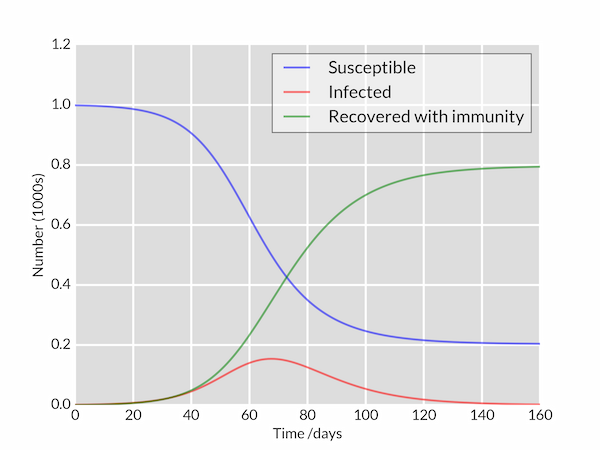

Ο κώδικας που θα παρουσιάσουμε είναι προσαρμοσμένος από αυτό το [blogpost](https://numbersandshapes.net/post/fitting_sir_to_data_in_python/)

In [985]:
recovered = load_countries(RECOVERED)
recovered, _ = data_over_number(recovered, 0, "Recovered")
# add the populations to the data
populations = [CountryInfo(country).population() for country in countries]